In [2]:
import pandas as pd

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
print("Train DataFrame Shape:", train.head(0))

Train DataFrame Shape: Empty DataFrame
Columns: [date_id, D1, D2, D3, D4, D5, D6, D7, D8, D9, E1, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E2, E20, E3, E4, E5, E6, E7, E8, E9, I1, I2, I3, I4, I5, I6, I7, I8, I9, M1, M10, M11, M12, M13, M14, M15, M16, M17, M18, M2, M3, M4, M5, M6, M7, M8, M9, P1, P10, P11, P12, P13, P2, P3, P4, P5, P6, P7, P8, P9, S1, S10, S11, S12, S2, S3, S4, S5, S6, S7, S8, S9, V1, V10, V11, V12, V13, V2, V3, V4, V5, V6, V7, V8, V9, forward_returns, risk_free_rate, market_forward_excess_returns]
Index: []

[0 rows x 98 columns]


In [5]:
print(f"Dataset Shape: {train.shape}")

# 2. Let's verify those feature groups. 
# We'll count how many columns start with each letter prefix.
prefixes = ['D', 'E', 'I', 'M', 'P', 'S', 'V', 'MOM']
for p in prefixes:
    count = len([c for c in train.columns if c.startswith(p)])
    print(f"Columns starting with '{p}': {count}")

# 3. Peek at the first few rows to see what the values actually look like
print("\nFirst 3 rows:")
print(train.head(3))

Dataset Shape: (9021, 98)
Columns starting with 'D': 9
Columns starting with 'E': 20
Columns starting with 'I': 9
Columns starting with 'M': 18
Columns starting with 'P': 13
Columns starting with 'S': 12
Columns starting with 'V': 13
Columns starting with 'MOM': 0

First 3 rows:
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  

[3 rows x 98 columns]


In [6]:
# 1. Check missing data % by group
prefixes = ['D', 'E', 'I', 'M', 'P', 'S', 'V']
print("Average Missing Data % by Group:")
for p in prefixes:
    cols = [c for c in train.columns if c.startswith(p)]
    missing_pct = train[cols].isnull().mean().mean() * 100
    print(f"{p}-features: {missing_pct:.1f}% missing")

# 2. Check if data improves over time
# We check how many valid (non-empty) features we have in early vs. late years
train['valid_count'] = train.notnull().sum(axis=1)

print("\nData Quality Timeline:")
print("Start of history (First 5 days):")
print(train[['date_id', 'valid_count']].head(5))

print("\nEnd of history (Last 5 days):")
print(train[['date_id', 'valid_count']].tail(5))

Average Missing Data % by Group:
D-features: 0.0% missing
E-features: 15.2% missing
I-features: 11.2% missing
M-features: 25.4% missing
P-features: 12.7% missing
S-features: 20.2% missing
V-features: 19.8% missing

Data Quality Timeline:
Start of history (First 5 days):
   date_id  valid_count
0        0           13
1        1           13
2        2           13
3        3           13
4        4           13

End of history (Last 5 days):
      date_id  valid_count
9016     9016           98
9017     9017           98
9018     9018           98
9019     9019           98
9020     9020           98


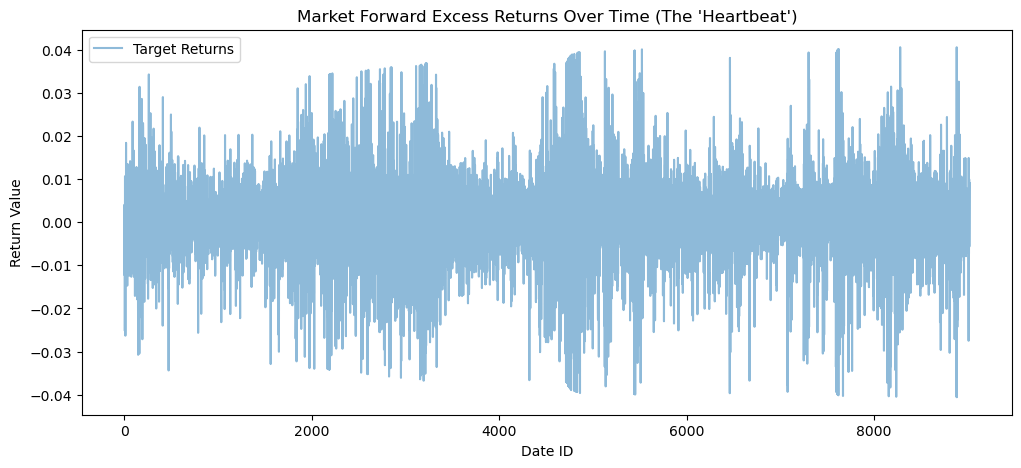

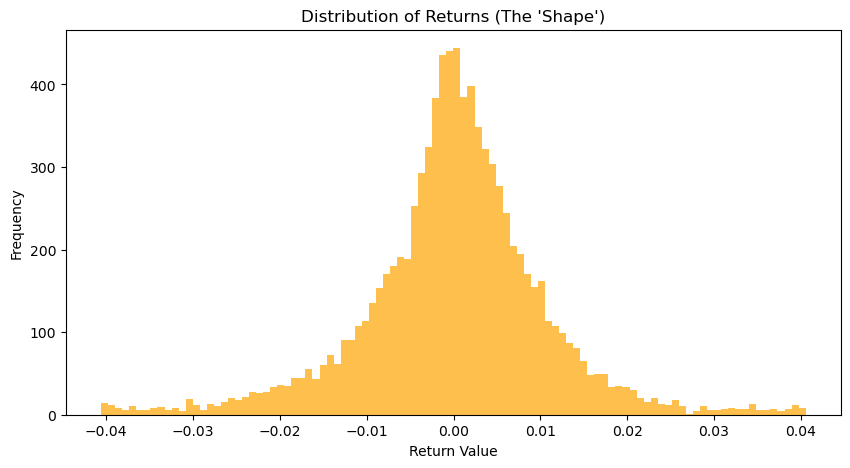

Max Return: 0.0405510761962616
Min Return: -0.0405819137459235
Mean Return: 5.3213773017774764e-05


In [7]:
import matplotlib.pyplot as plt

# 1. Plot the Target over time
plt.figure(figsize=(12, 5))
plt.plot(train['market_forward_excess_returns'], alpha=0.5, label='Target Returns')
plt.title("Market Forward Excess Returns Over Time (The 'Heartbeat')")
plt.xlabel("Date ID")
plt.ylabel("Return Value")
plt.legend()
plt.show()

# 2. Check the "Distribution" (Is it a Bell Curve?)
plt.figure(figsize=(10, 5))
plt.hist(train['market_forward_excess_returns'], bins=100, alpha=0.7, color='orange')
plt.title("Distribution of Returns (The 'Shape')")
plt.xlabel("Return Value")
plt.ylabel("Frequency")
plt.show()

# 3. Basic Stats
print("Max Return:", train['market_forward_excess_returns'].max())
print("Min Return:", train['market_forward_excess_returns'].min())
print("Mean Return:", train['market_forward_excess_returns'].mean())

In [8]:
import numpy as np
import pandas as pd
import pandas.api.types

MIN_INVESTMENT = 0
MAX_INVESTMENT = 2


class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ParticipantVisibleError('Division by zero, strategy std is zero')
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    if market_volatility == 0:
        raise ParticipantVisibleError('Division by zero, market std is zero')

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

In [9]:
# 1. Re-create the 'Lazy' Strategy (just in case it was lost)
train['lazy_allocation'] = 1.0

# 2. Prepare the 'solution' dataframe (The Truth)
solution = train[['date_id', 'forward_returns', 'risk_free_rate']].copy()

# 3. Prepare the 'submission' dataframe (Our Answers)
submission = pd.DataFrame({'prediction': train['lazy_allocation']})

# 4. Calculate the Official Score
try:
    official_score = score(solution, submission, 'date_id')
    print(f"Official Competition Score: {official_score:.6f}")
except Exception as e:
    print(f"Error: {e}")

Official Competition Score: 0.465048


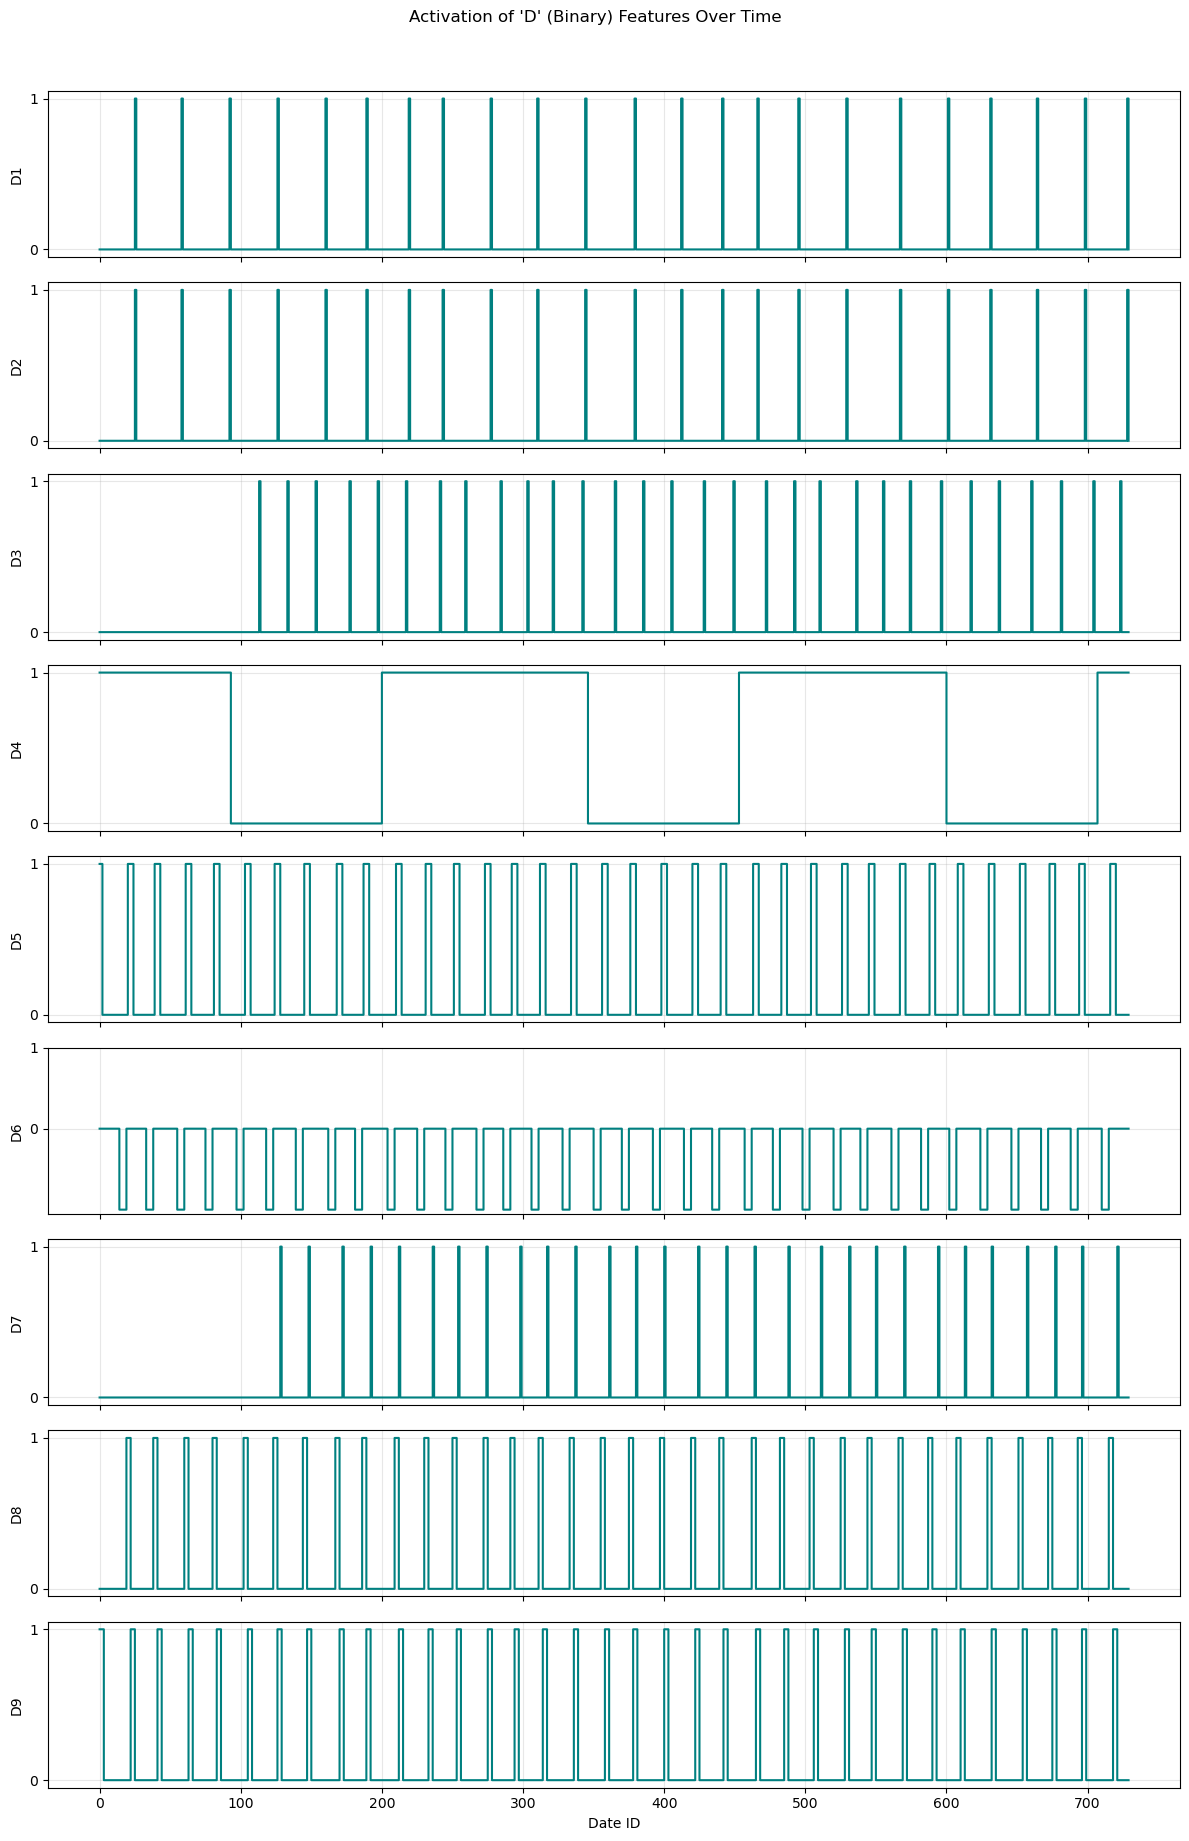

Frequency Analysis (How often is the switch 'ON'?):
D1: Active 3.2% of the time
D2: Active 3.2% of the time
D3: Active 4.1% of the time
D4: Active 56.0% of the time
D5: Active 18.9% of the time
D6: Active -23.3% of the time
D7: Active 4.0% of the time
D8: Active 14.0% of the time
D9: Active 14.4% of the time


In [10]:
import matplotlib.pyplot as plt

d_cols = [c for c in train.columns if c.startswith('D')]

fig, axes = plt.subplots(len(d_cols), 1, figsize=(12, 2 * len(d_cols)), sharex=True)

for i, col in enumerate(d_cols):
    # 'steps-post' is perfect for binary data (square waves)
    axes[i].plot(train[:730]['date_id'], train[col][:730], drawstyle='steps-post', color='teal')
    axes[i].set_ylabel(col)
    axes[i].set_yticks([0, 1])  # Force y-axis to only show 0 and 1
    axes[i].grid(True, alpha=0.3)

plt.xlabel('Date ID')
plt.suptitle("Activation of 'D' (Binary) Features Over Time", y=1.02)
plt.tight_layout()
plt.show()

# 3. The Numbers: How rare are these events?
print("Frequency Analysis (How often is the switch 'ON'?):")
for col in d_cols:
    # The mean of a 0/1 column tells us the percentage of time it is 1
    frequency = train[col][:730].mean() * 100
    print(f"{col}: Active {frequency:.1f}% of the time")

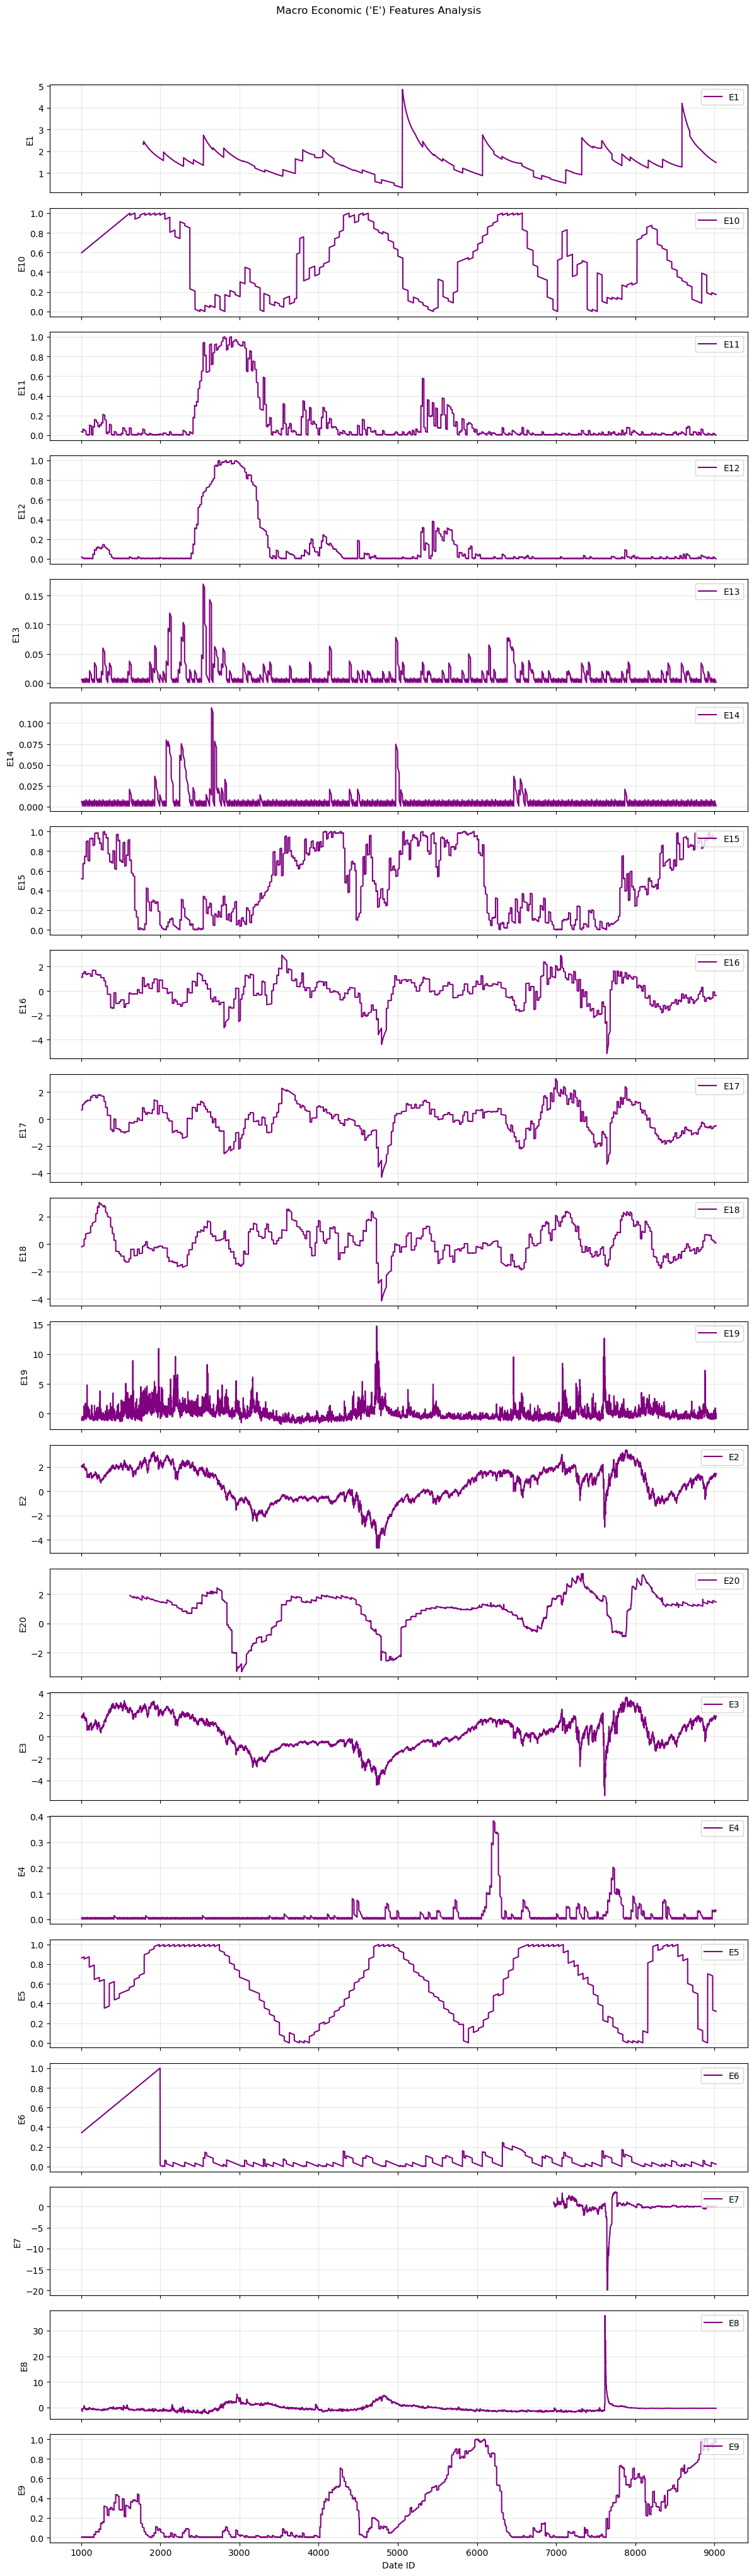

Granularity Check (Low count = Step-like data):
E1: 7237 unique values (out of 9021 days)
E10: 2859 unique values (out of 9021 days)
E11: 1519 unique values (out of 9021 days)
E12: 1321 unique values (out of 9021 days)
E13: 315 unique values (out of 9021 days)
E14: 216 unique values (out of 9021 days)
E15: 2597 unique values (out of 9021 days)
E16: 7941 unique values (out of 9021 days)
E17: 7968 unique values (out of 9021 days)
E18: 7977 unique values (out of 9021 days)
E19: 8015 unique values (out of 9021 days)
E2: 8015 unique values (out of 9021 days)
E20: 7405 unique values (out of 9021 days)
E3: 8015 unique values (out of 9021 days)
E4: 443 unique values (out of 9021 days)
E5: 2649 unique values (out of 9021 days)
E6: 1551 unique values (out of 9021 days)
E7: 2052 unique values (out of 9021 days)
E8: 8002 unique values (out of 9021 days)
E9: 2277 unique values (out of 9021 days)


In [11]:
import matplotlib.pyplot as plt

# 1. Select the first 10 'E' columns
e_cols = [c for c in train.columns if c.startswith('E')]

# 2. Plot them
fig, axes = plt.subplots(len(e_cols), 1, figsize=(12, 2 * len(e_cols)), sharex=True)

for i, col in enumerate(e_cols):
    # Using standard plot to see the natural shape
    axes[i].plot(train['date_id'], train[col], color='purple', label=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.xlabel('Date ID')
plt.suptitle("Macro Economic ('E') Features Analysis", y=1.02)
plt.tight_layout()
plt.show()

# 3. The "Step" Test: Count unique values
# If a feature changes every day (like price), it has thousands of unique values.
# If it changes monthly (like unemployment), it has very few.
print("Granularity Check (Low count = Step-like data):")
for col in e_cols:
    unique_count = train[col].nunique()
    print(f"{col}: {unique_count} unique values (out of {len(train)} days)")

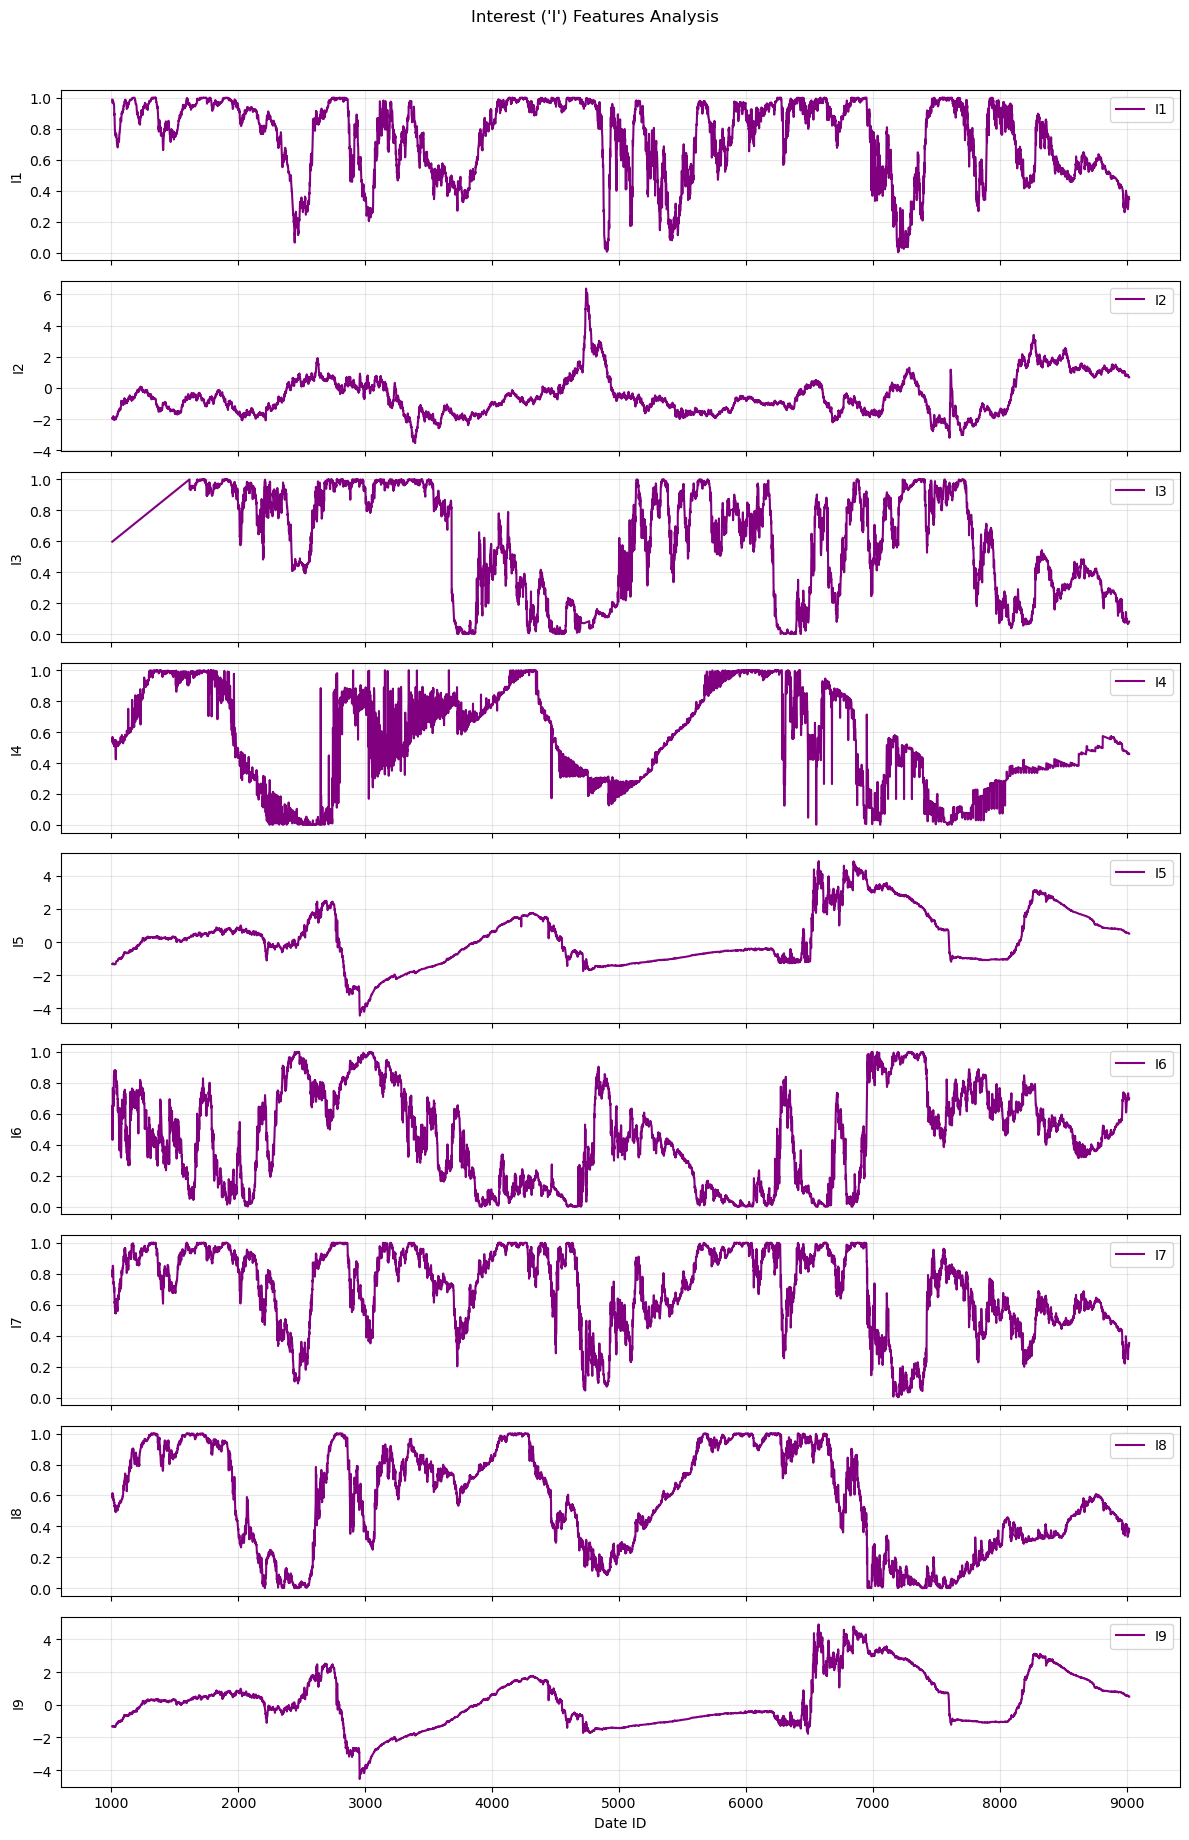

Granularity Check (Low count = Step-like data):
I1: 2267 unique values (out of 9021 days)
I2: 8015 unique values (out of 9021 days)
I3: 2139 unique values (out of 9021 days)
I4: 2645 unique values (out of 9021 days)
I5: 8013 unique values (out of 9021 days)
I6: 1497 unique values (out of 9021 days)
I7: 2096 unique values (out of 9021 days)
I8: 2286 unique values (out of 9021 days)
I9: 8013 unique values (out of 9021 days)


In [12]:
import matplotlib.pyplot as plt

# 1. Select the first 10 'I' columns
i_cols = [c for c in train.columns if c.startswith('I')]

# 2. Plot them
fig, axes = plt.subplots(len(i_cols), 1, figsize=(12, 2 * len(i_cols)), sharex=True)
for i, col in enumerate(i_cols):
    # Using standard plot to see the natural shape
    axes[i].plot(train['date_id'], train[col], color='purple', label=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.xlabel('Date ID')
plt.suptitle("Interest ('I') Features Analysis", y=1.02)
plt.tight_layout()
plt.show()

# 3. The "Step" Test: Count unique values
# If a feature changes every day (like price), it has thousands of unique values.
# If it changes monthly (like unemployment), it has very few.
print("Granularity Check (Low count = Step-like data):")
for col in i_cols:
    unique_count = train[col].nunique()
    print(f"{col}: {unique_count} unique values (out of {len(train)} days)")

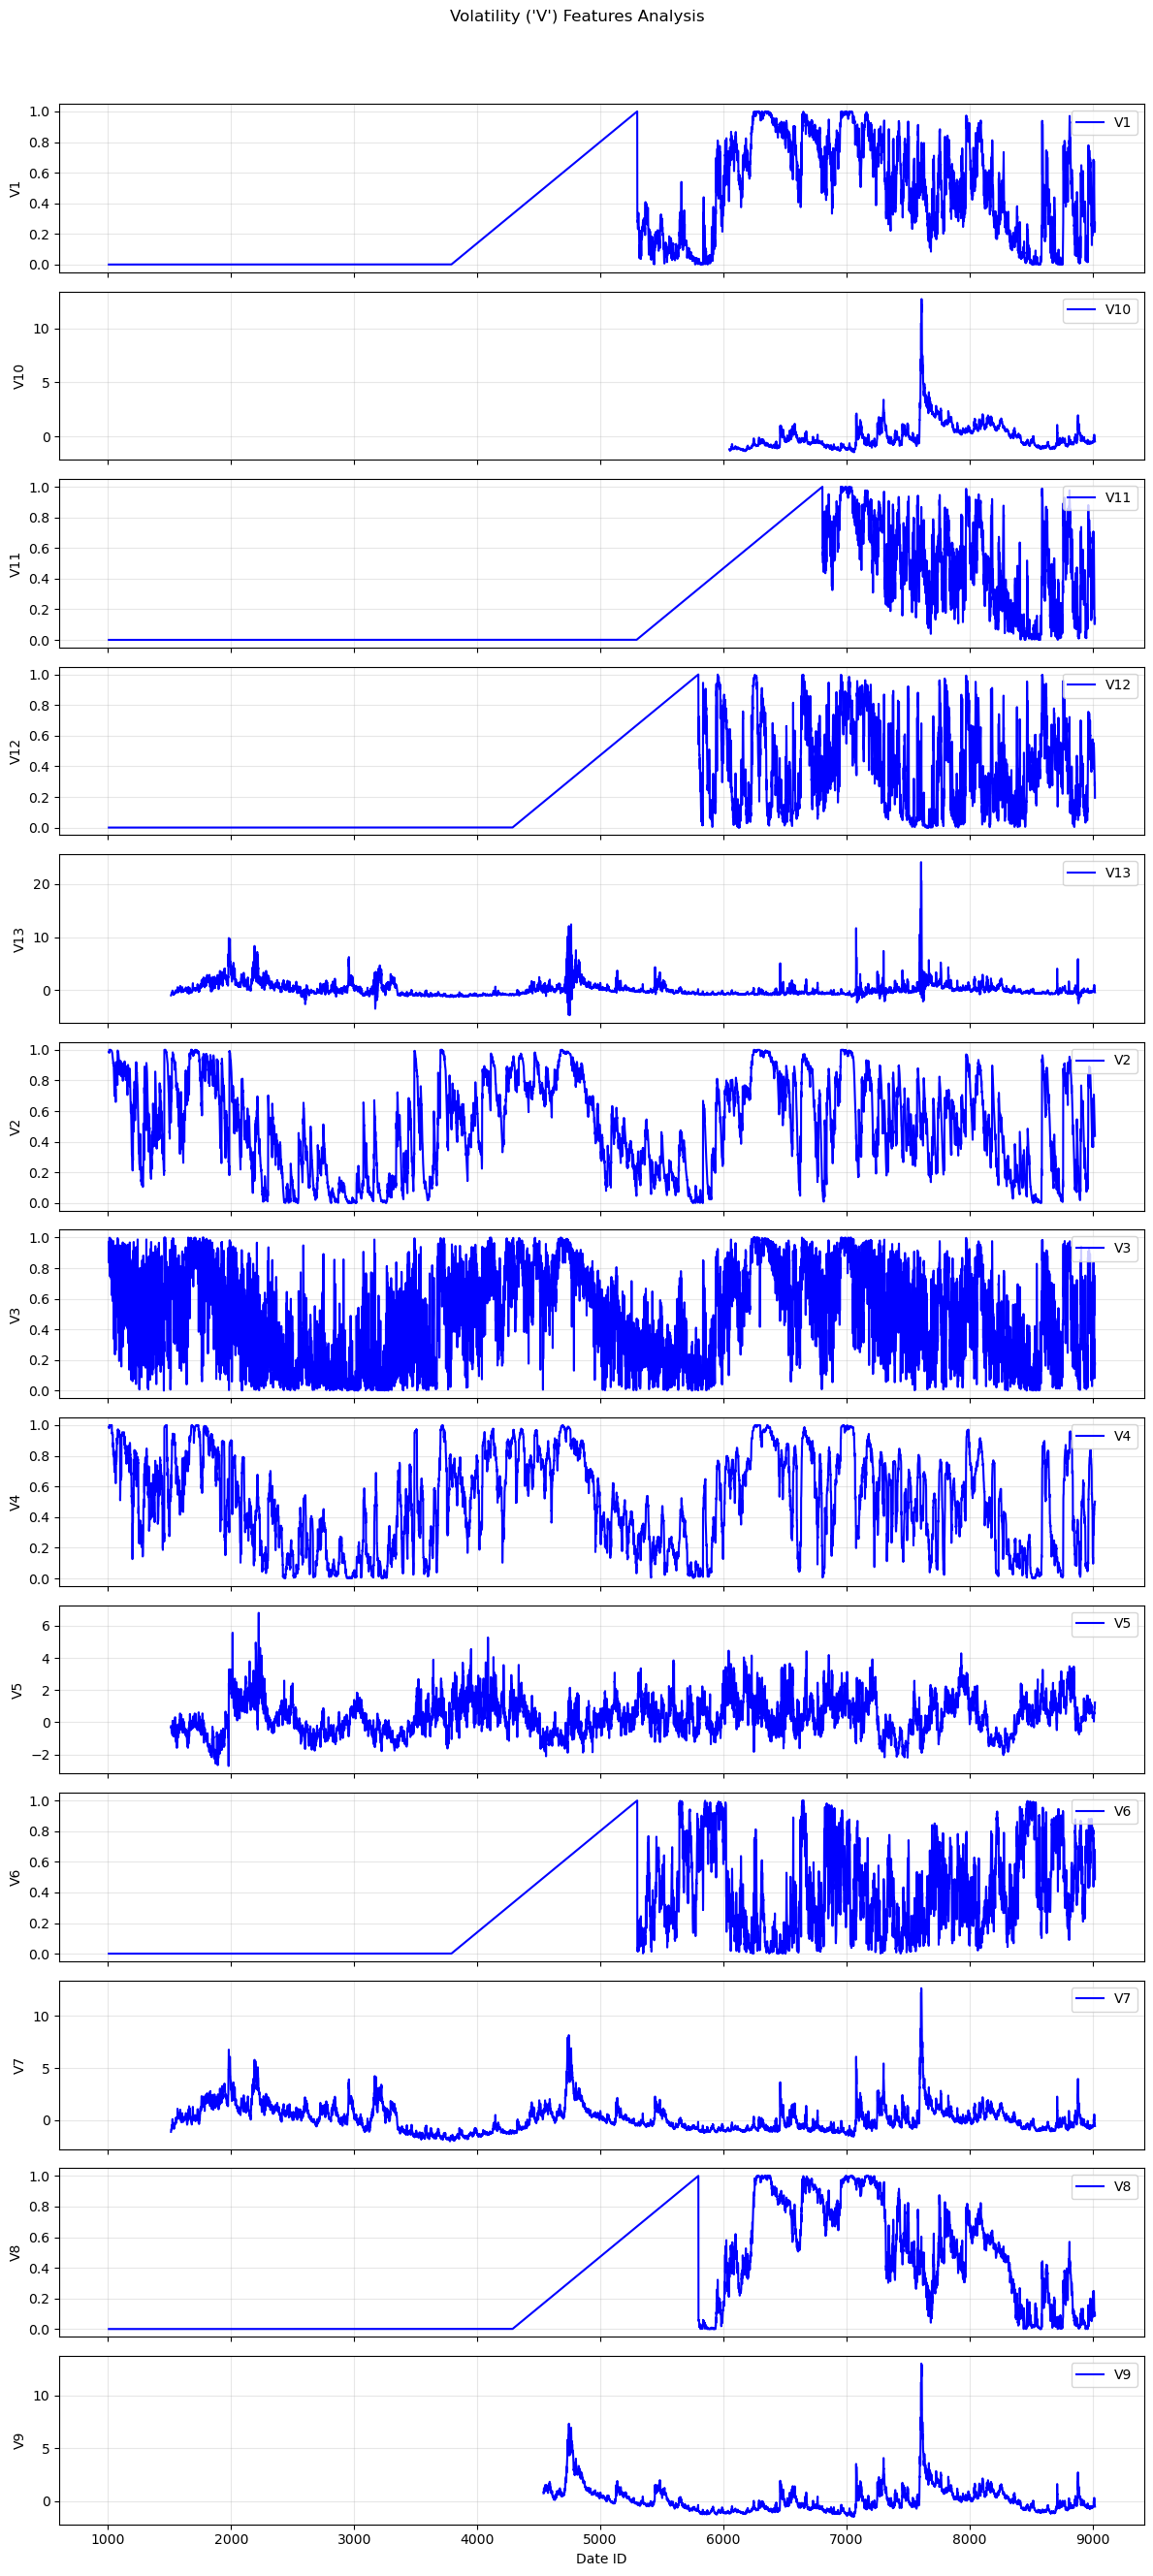

Granularity Check (Low count = Step-like data):
V1: 1524 unique values (out of 9021 days)
V10: 2972 unique values (out of 9021 days)
V11: 2152 unique values (out of 9021 days)
V12: 2101 unique values (out of 9021 days)
V13: 7510 unique values (out of 9021 days)
V2: 1500 unique values (out of 9021 days)
V3: 1501 unique values (out of 9021 days)
V4: 1499 unique values (out of 9021 days)
V5: 7509 unique values (out of 9021 days)
V6: 1514 unique values (out of 9021 days)
V7: 7510 unique values (out of 9021 days)
V8: 2293 unique values (out of 9021 days)
V9: 4482 unique values (out of 9021 days)


In [13]:
import matplotlib.pyplot as plt

# 1. Select all 'V' columns (Volatility)
v_cols = [c for c in train.columns if c.startswith('V')]

# 2. Plot them
fig, axes = plt.subplots(len(v_cols), 1, figsize=(12, 2 * len(v_cols)), sharex=True)
for i, col in enumerate(v_cols):
    # Using standard plot to see the natural shape
    axes[i].plot(train['date_id'], train[col], color='blue', label=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.xlabel('Date ID')
plt.suptitle("Volatility ('V') Features Analysis", y=1.02)
plt.tight_layout()
plt.show()

# 3. The "Step" Test: Count unique values
# If a feature changes every day (like price), it has thousands of unique values.
# If it changes monthly (like unemployment), it has very few.
print("Granularity Check (Low count = Step-like data):")
for col in v_cols:
    unique_count = train[col].nunique()
    print(f"{col}: {unique_count} unique values (out of {len(train)} days)")

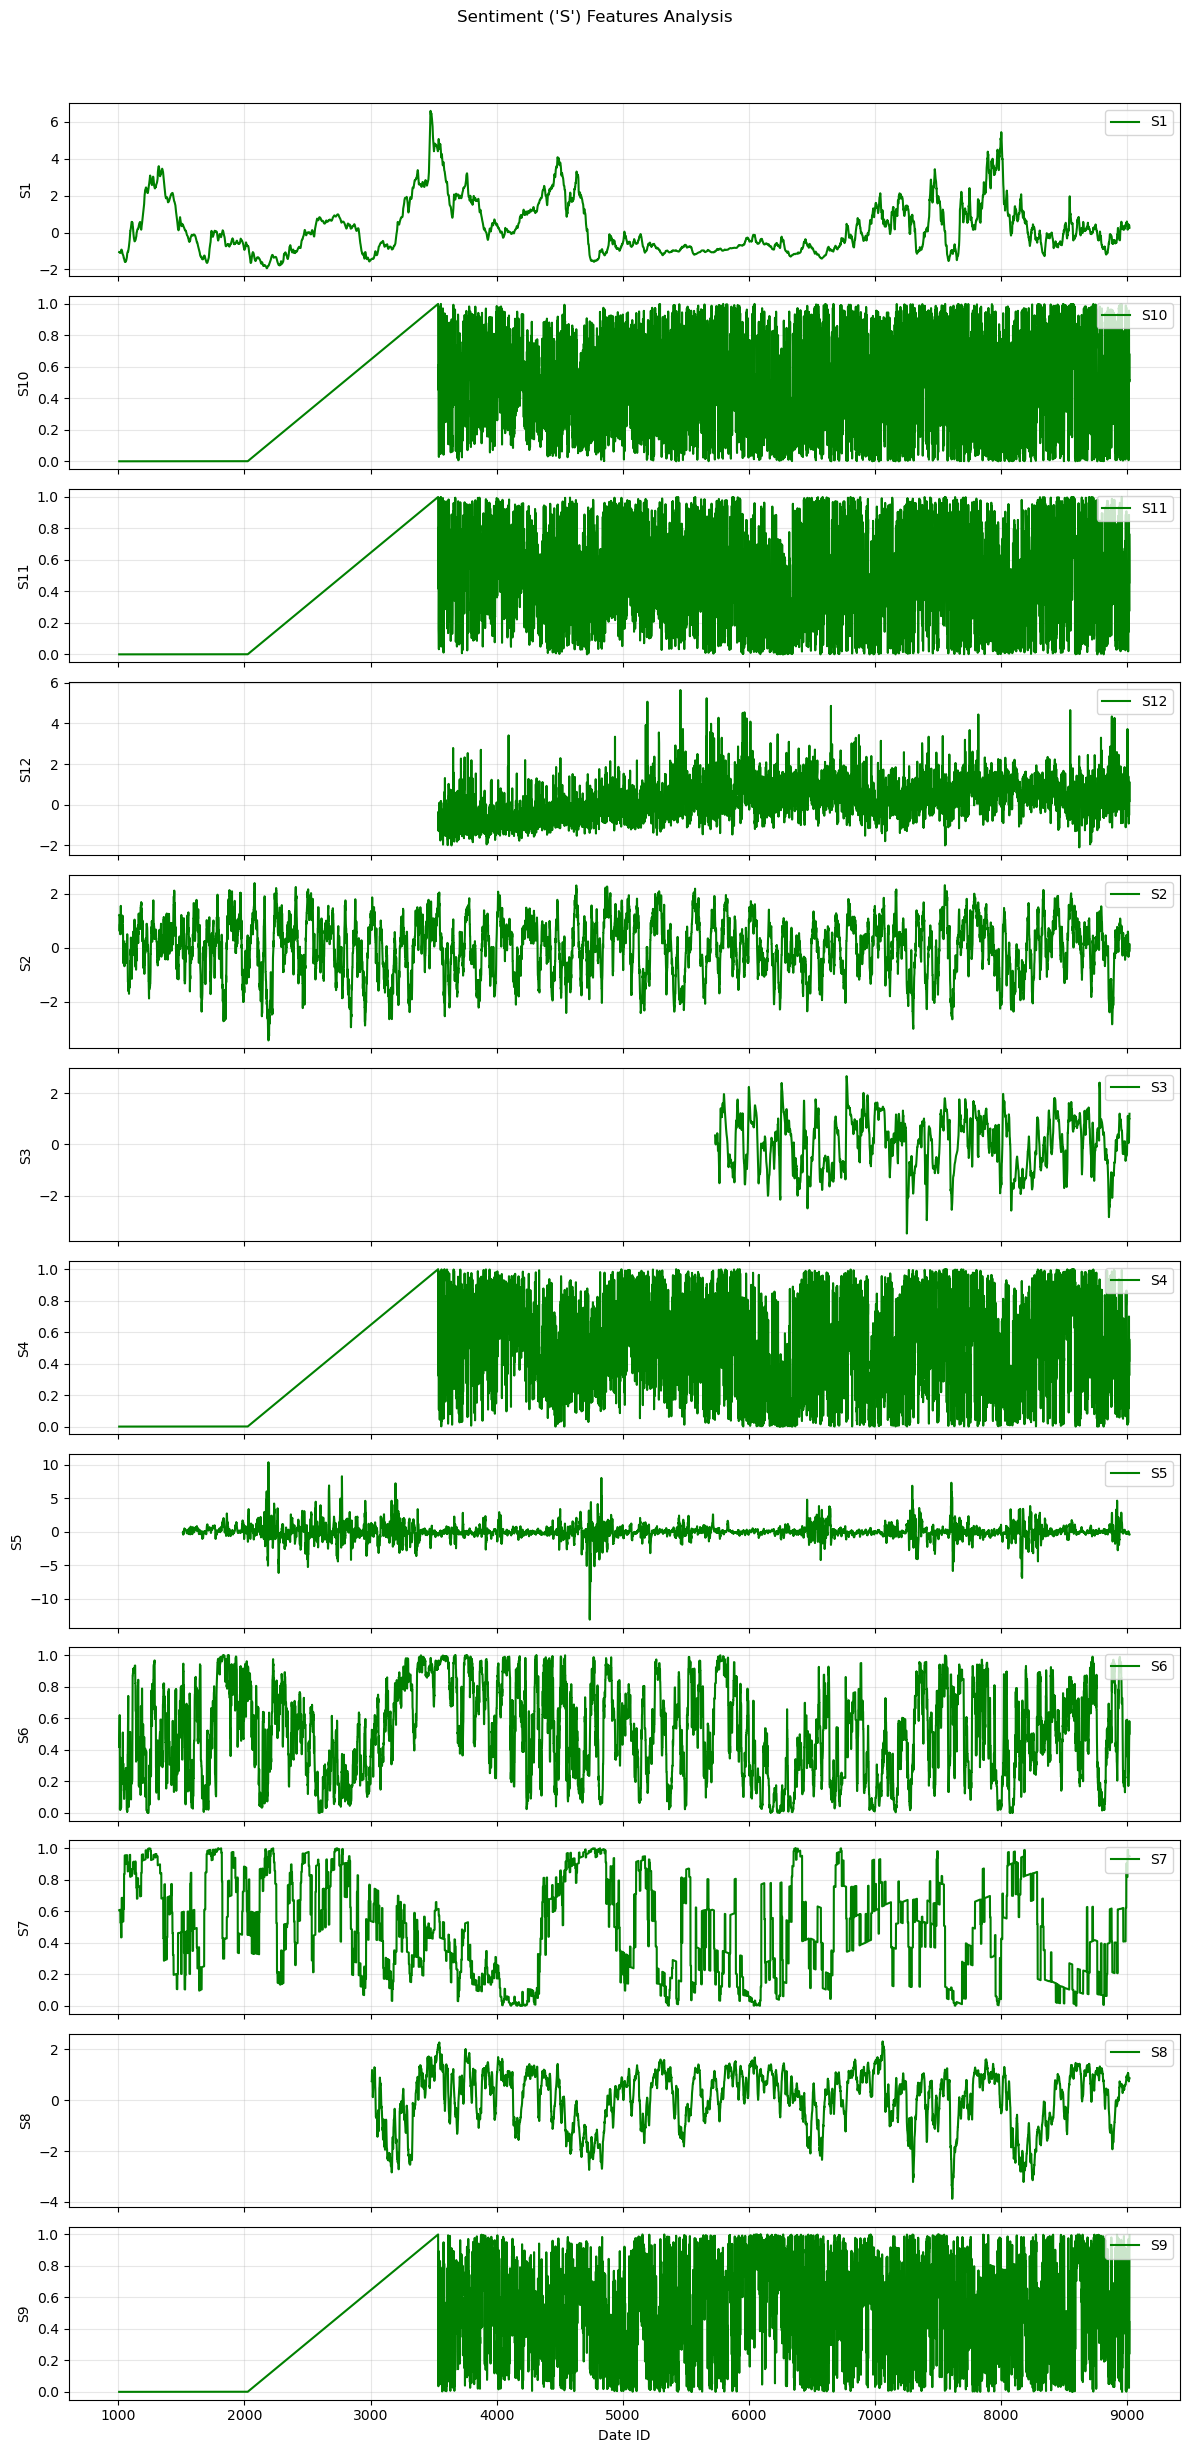

Granularity Check (Low count = Step-like data):
S1: 8015 unique values (out of 9021 days)
S10: 1549 unique values (out of 9021 days)
S11: 1535 unique values (out of 9021 days)
S12: 5484 unique values (out of 9021 days)
S2: 8006 unique values (out of 9021 days)
S3: 3288 unique values (out of 9021 days)
S4: 1533 unique values (out of 9021 days)
S5: 7510 unique values (out of 9021 days)
S6: 2714 unique values (out of 9021 days)
S7: 2789 unique values (out of 9021 days)
S8: 6012 unique values (out of 9021 days)
S9: 1847 unique values (out of 9021 days)


In [14]:
import matplotlib.pyplot as plt

# 1. Select all 'S' columns (Sentiment)
s_cols = [c for c in train.columns if c.startswith('S')]

# 2. Plot them
fig, axes = plt.subplots(len(s_cols), 1, figsize=(12, 2 * len(s_cols)), sharex=True)
for i, col in enumerate(s_cols):
    # Using standard plot to see the natural shape
    axes[i].plot(train['date_id'], train[col], color='green', label=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.xlabel('Date ID')
plt.suptitle("Sentiment ('S') Features Analysis", y=1.02)
plt.tight_layout()
plt.show()

# 3. The "Step" Test: Count unique values
# If a feature changes every day (like price), it has thousands of unique values.
# If it changes monthly (like unemployment), it has very few.
print("Granularity Check (Low count = Step-like data):")
for col in s_cols:
    unique_count = train[col].nunique()
    print(f"{col}: {unique_count} unique values (out of {len(train)} days)")

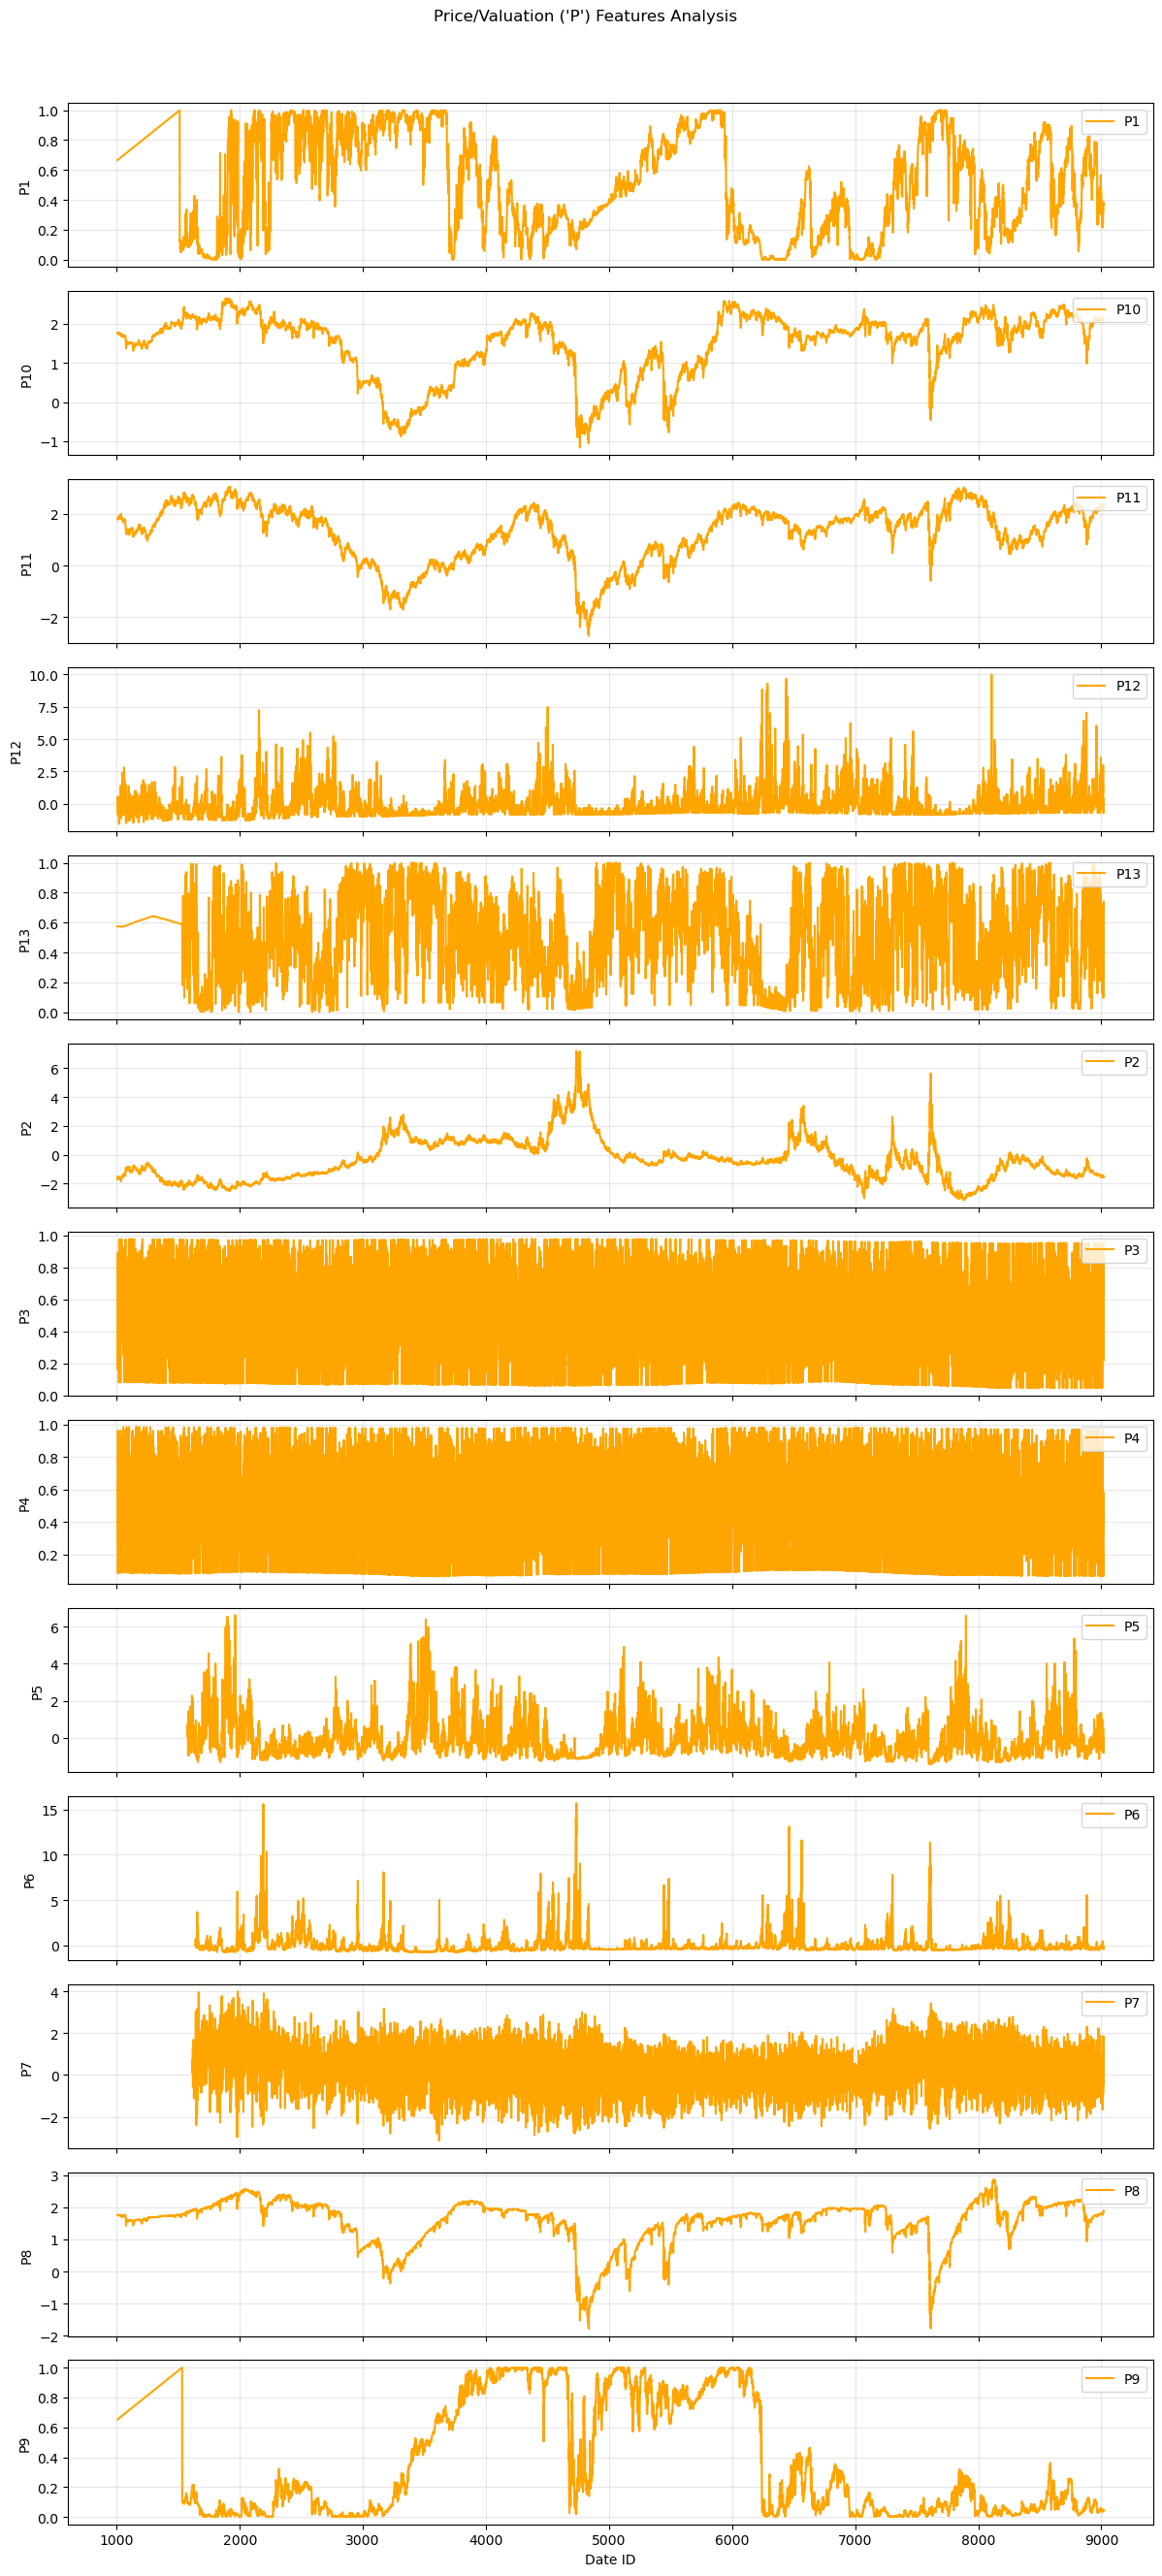

Granularity Check (Low count = Step-like data):
P1: 2561 unique values (out of 9021 days)
P10: 8015 unique values (out of 9021 days)
P11: 8015 unique values (out of 9021 days)
P12: 7492 unique values (out of 9021 days)
P13: 2779 unique values (out of 9021 days)
P2: 8015 unique values (out of 9021 days)
P3: 2539 unique values (out of 9021 days)
P4: 2451 unique values (out of 9021 days)
P5: 7447 unique values (out of 9021 days)
P6: 7375 unique values (out of 9021 days)
P7: 7405 unique values (out of 9021 days)
P8: 8015 unique values (out of 9021 days)
P9: 1764 unique values (out of 9021 days)


In [15]:
import matplotlib.pyplot as plt

# 1. Select all 'P' columns (Price/Valuation)
p_cols = [c for c in train.columns if c.startswith('P')]

# 2. Plot them
fig, axes = plt.subplots(len(p_cols), 1, figsize=(12, 2 * len(p_cols)), sharex=True)
for i, col in enumerate(p_cols):
    # Using standard plot to see the natural shape
    axes[i].plot(train['date_id'], train[col], color='orange', label=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.xlabel('Date ID')
plt.suptitle("Price/Valuation ('P') Features Analysis", y=1.02)
plt.tight_layout()
plt.show()

# 3. The "Step" Test: Count unique values
# If a feature changes every day (like price), it has thousands of unique values.
# If it changes monthly (like unemployment), it has very few.
print("Granularity Check (Low count = Step-like data):")
for col in p_cols:
    unique_count = train[col].nunique()
    print(f"{col}: {unique_count} unique values (out of {len(train)} days)")

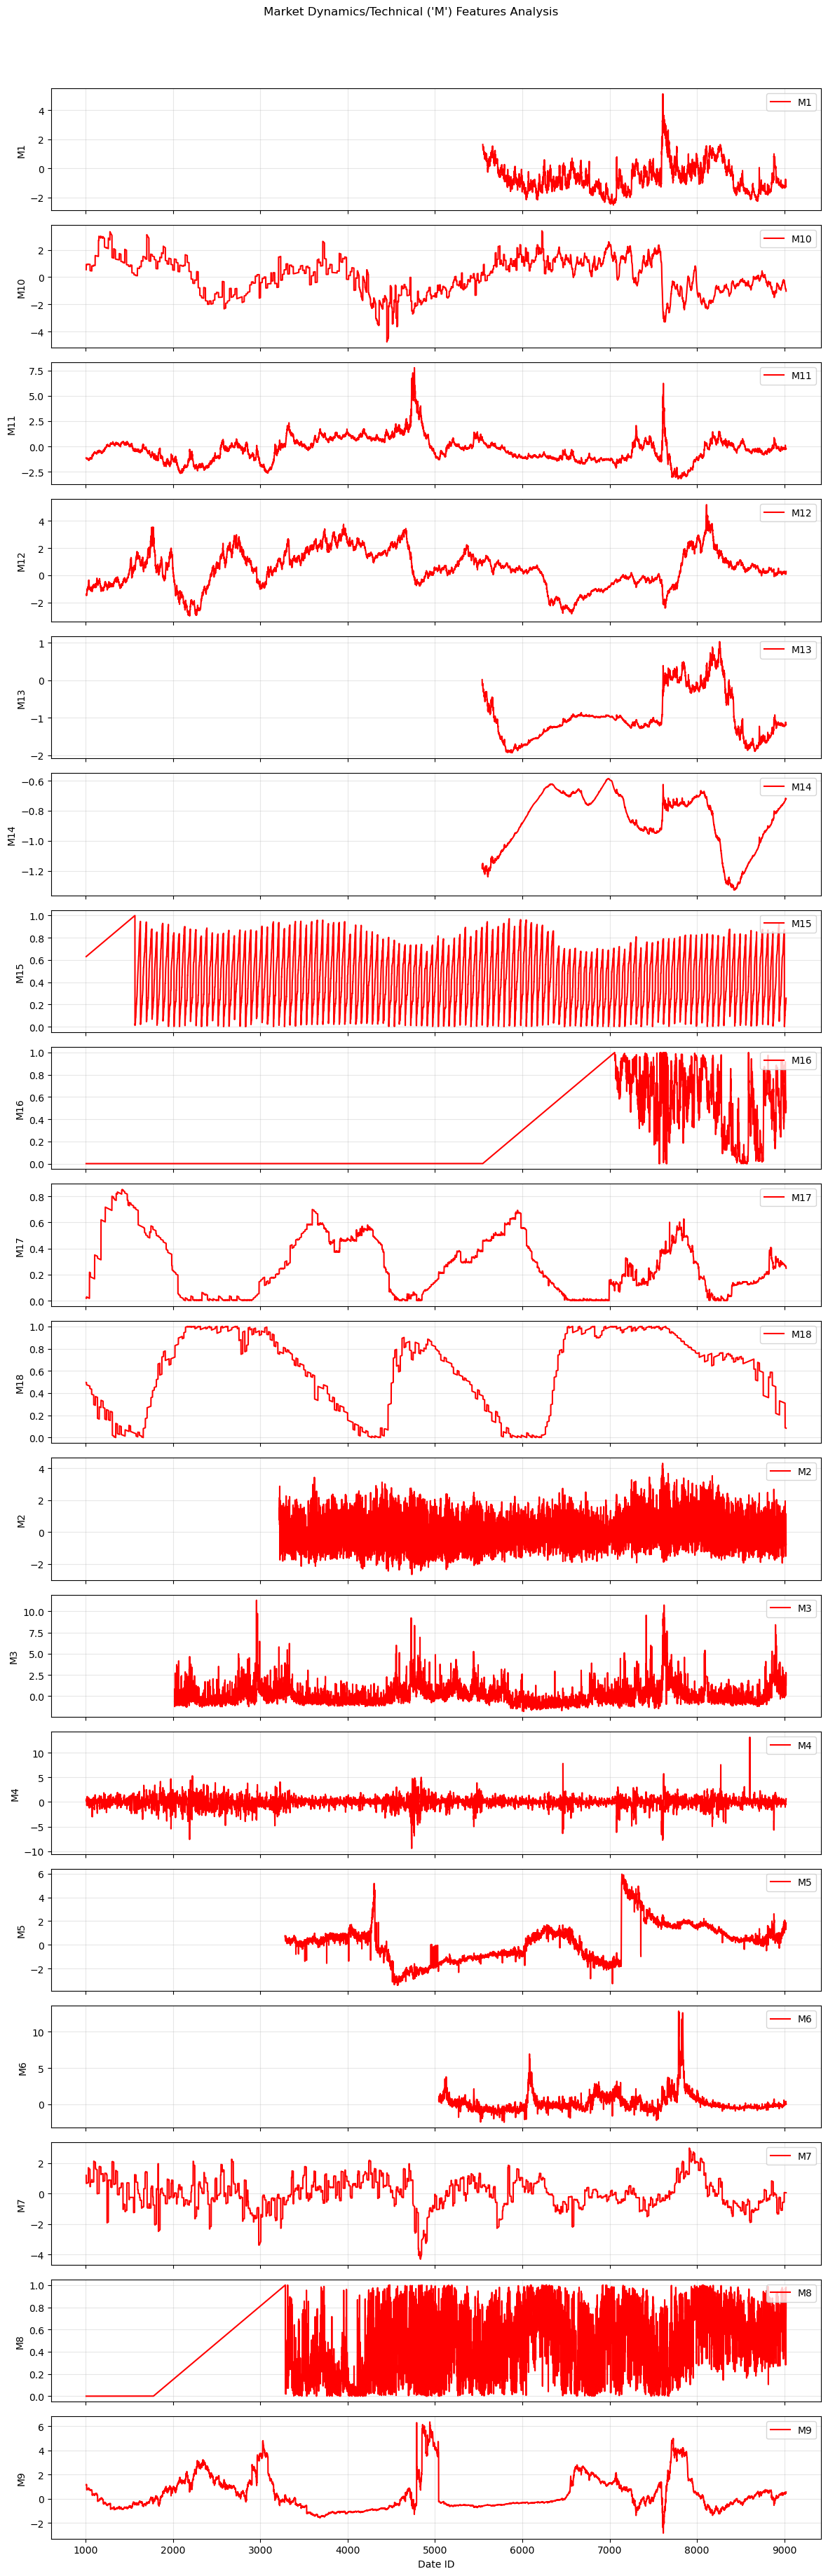

Granularity Check (Low count = Step-like data):
M1: 3474 unique values (out of 9021 days)
M10: 8003 unique values (out of 9021 days)
M11: 8015 unique values (out of 9021 days)
M12: 8015 unique values (out of 9021 days)
M13: 3481 unique values (out of 9021 days)
M14: 3481 unique values (out of 9021 days)
M15: 2702 unique values (out of 9021 days)
M16: 1528 unique values (out of 9021 days)
M17: 2024 unique values (out of 9021 days)
M18: 2697 unique values (out of 9021 days)
M2: 5804 unique values (out of 9021 days)
M3: 7003 unique values (out of 9021 days)
M4: 8015 unique values (out of 9021 days)
M5: 5738 unique values (out of 9021 days)
M6: 3978 unique values (out of 9021 days)
M7: 8015 unique values (out of 9021 days)
M8: 2795 unique values (out of 9021 days)
M9: 8015 unique values (out of 9021 days)


In [16]:
import matplotlib.pyplot as plt

# 1. Select all 'M' columns (Market Dynamics/Technical)
m_cols = [c for c in train.columns if c.startswith('M')]

# 2. Plot them
fig, axes = plt.subplots(len(m_cols), 1, figsize=(12, 2 * len(m_cols)), sharex=True)
for i, col in enumerate(m_cols):
    # Using standard plot to see the natural shape
    axes[i].plot(train['date_id'], train[col], color='red', label=col)
    axes[i].set_ylabel(col)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper right')

plt.xlabel('Date ID')
plt.suptitle("Market Dynamics/Technical ('M') Features Analysis", y=1.02)
plt.tight_layout()
plt.show()

# 3. The "Step" Test: Count unique values
# If a feature changes every day (like price), it has thousands of unique values.
# If it changes monthly (like unemployment), it has very few.
print("Granularity Check (Low count = Step-like data):")
for col in m_cols:
    unique_count = train[col].nunique()
    print(f"{col}: {unique_count} unique values (out of {len(train)} days)")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np

feature_cols = [c for c in train.columns if c not in ['date_id', 'forward_returns', 'risk_free_rate', 
                                                      'market_forward_excess_returns', 'valid_count', 
                                                      'lazy_allocation', 'lazy_return', 'is_scored']]
target_col = 'market_forward_excess_returns'

# --- STEP 1: CLEAN THE DATA (The Fix) ---
# We fill NaNs with 0 to prevent "poisoning" the scaler
X_clean = train[feature_cols].fillna(0).astype(float) # Ensure all numbers are floats
y_clean = train[target_col].fillna(0).astype(float)

# --- STEP 2: SCALE & SHAPE ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
y_scaled = y_clean.values

# Re-run the windowing function
def create_sequences(data, target, seq_length=10):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10
X_3d, y_3d = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

# Split again
split = int(len(X_3d) * 0.8)
X_train_seq = torch.tensor(X_3d[:split], dtype=torch.float32)
y_train_seq = torch.tensor(y_3d[:split], dtype=torch.float32).unsqueeze(1)
X_test_seq = torch.tensor(X_3d[split:], dtype=torch.float32)
y_test_seq = torch.tensor(y_3d[split:], dtype=torch.float32).unsqueeze(1)

Using device: cpu
Training Ensemble of 3 models...
Training Ensemble of 3 models...


100%|██████████| 3/3 [01:53<00:00, 37.90s/it]




--- FINAL RESULTS ---
Market (Buy & Hold) Sharpe: 0.2972
Hybrid Ensemble Sharpe:     0.3561


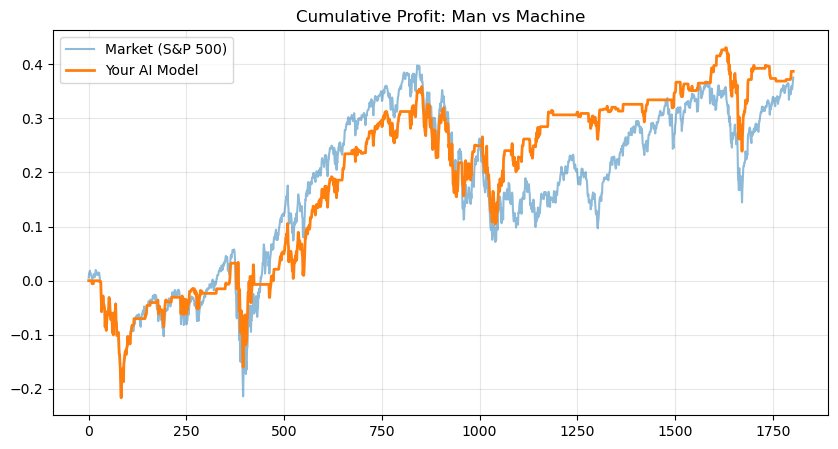

In [26]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------------------
# 1. Config & Device
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Ensembling: We will train 3 models with different seeds and average them
SEEDS = [42, 101, 2023]
TARGET_SCALE = 100.0  # Scale targets up by 100x to help gradient flow

# ---------------------------
# 2. Data Preparation (With Scaling)
# ---------------------------
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32) if not torch.is_tensor(x) else x.float()

# Assuming X_train_seq, etc. exist from previous steps
X_train_t = to_tensor(X_train_seq)
X_test_t  = to_tensor(X_test_seq)

# Scale Targets! (Crucial for regression)
y_train_raw = to_tensor(y_train_seq).reshape(-1, 1)
y_test_raw  = to_tensor(y_test_seq).reshape(-1, 1)

y_train_t = y_train_raw * TARGET_SCALE
y_test_t  = y_test_raw * TARGET_SCALE

# Feature Standardization
feat_mean = X_train_t.mean(dim=(0,1), keepdim=True)
feat_std  = X_train_t.std(dim=(0,1), keepdim=True) + 1e-8
X_train_t = (X_train_t - feat_mean) / feat_std
X_test_t  = (X_test_t  - feat_mean) / feat_std

# ---------------------------
# 3. The Model (Same Hybrid Architecture)
# ---------------------------
class ResidualConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding)
        self.ln1 = nn.LayerNorm(out_ch)
        self.act = nn.GELU()
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding)
        self.ln2 = nn.LayerNorm(out_ch)
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        residual = x if self.down is None else self.down(x)
        out = self.act(self.ln1(self.conv1(x).transpose(1,2)).transpose(1,2))
        out = self.act(self.ln2(self.conv2(out).transpose(1,2)).transpose(1,2))
        return out + residual

class AttentionPool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.v = nn.Parameter(torch.randn(dim))
    def forward(self, x):
        scores = torch.tanh(x) @ self.v
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)
        return (x * weights).sum(dim=1)

class HybridModel(nn.Module):
    def __init__(self, n_features, conv_channels=64, lstm_hidden=64, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Conv1d(n_features, conv_channels, kernel_size=1)
        self.res1 = ResidualConvBlock(conv_channels, conv_channels)
        self.dropout = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(conv_channels, lstm_hidden, batch_first=True, bidirectional=True)
        self.attn = AttentionPool(lstm_hidden * 2)
        self.head = nn.Linear(lstm_hidden * 2, 1)

    def forward(self, x):
        x = x.transpose(1, 2) # (N, Feat, Seq)
        x = self.input_proj(x)
        x = self.res1(x)
        x = self.dropout(x)
        x = x.transpose(1, 2) # Back to (N, Seq, Feat) for LSTM
        lstm_out, _ = self.bilstm(x)
        pooled = self.attn(lstm_out)
        return self.head(pooled)

# ---------------------------
# 4. Training Function
# ---------------------------
def train_one_seed(seed):
    # Set Seed
    random.seed(seed)
    torch.manual_seed(seed)
    
    # Dataloaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds  = TensorDataset(X_test_t,  y_test_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)
    
    model = HybridModel(n_features=X_train_t.shape[2]).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss() # Better than SmoothL1 for finance
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    # Training Loop
    for epoch in range(15): # Max epochs
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(Xb), yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                val_loss += criterion(model(Xb), yb).item()
        
        # Save Best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 4: # Early Stop
                break
                
    # Return best model predictions on test set
    model.load_state_dict(best_model_state)
    model.eval()
    preds = []
    with torch.no_grad():
        for Xb, _ in test_loader:
            preds.append(model(Xb.to(DEVICE)).cpu().numpy())
    return np.vstack(preds)

# ---------------------------
# 5. Ensemble Execution
# ---------------------------
print(f"Training Ensemble of {len(SEEDS)} models...")
all_preds = []

for seed in tqdm(SEEDS):
    preds = train_one_seed(seed)
    all_preds.append(preds)

# Average predictions (Ensemble)
ensemble_preds_scaled = np.mean(all_preds, axis=0).flatten()
# Unscale back to real returns
final_predictions = ensemble_preds_scaled / TARGET_SCALE

# ---------------------------
# 6. Evaluation (Corrected Logic)
# ---------------------------
actual_returns = y_test_raw.numpy().flatten()

# STRATEGY LOGIC:
# We are only allowed 0 to 2. No shorting (-1).
# Rule: If prediction > 0, Buy (1.0). If prediction <= 0, Cash (0.0).
allocation = np.where(final_predictions > 0, 1.0, 0.0)

strategy_returns = allocation * actual_returns
market_returns = actual_returns # Buy & Hold (Allocation = 1.0 always)

# Sharpe Calculation
def get_sharpe(ret):
    return (ret.mean() / (ret.std() + 1e-8)) * np.sqrt(252)

my_sharpe = get_sharpe(strategy_returns)
market_sharpe = get_sharpe(market_returns)

print(f"\n--- FINAL RESULTS ---")
print(f"Market (Buy & Hold) Sharpe: {market_sharpe:.4f}")
print(f"Hybrid Ensemble Sharpe:     {my_sharpe:.4f}")

# ---------------------------
# 7. Visualization
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(market_returns), label=f'Market (S&P 500)', alpha=0.5)
plt.plot(np.cumsum(strategy_returns), label=f'Your AI Model', linewidth=2)
plt.title("Cumulative Profit: Man vs Machine")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()